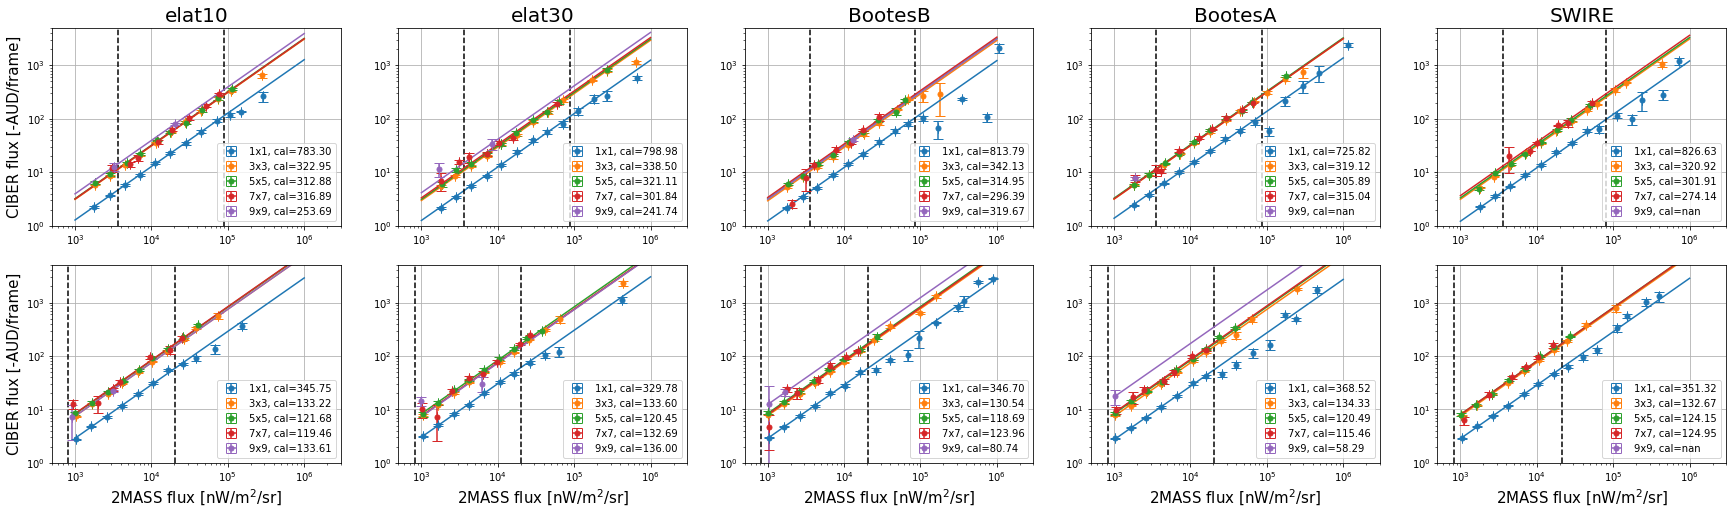

In [262]:
from reduction import *
data_maps = {1: image_reduction(1), 2: image_reduction(2)}
fig, ax = plt.subplots(2,5,figsize=(30,8))
calfac_data = {}
for inst in [1,2]:
    calfac_data[inst] = {}
    data = data_maps[inst]
    if inst==1:
        fitmaglim = (12.5,16)
    else:
        fitmaglim = (13.5,17)
        
    for ifield in [4,5,6,7,8]:
        calfac_data[inst][ifield] = {}
        mapin = -data.stackmapdat[ifield]['map'].copy()
        mask_inst =  data.stackmapdat[ifield]['mask_inst'].copy()
        strnum = data.stackmapdat[ifield]['strnum'].copy()
        strmask = data.stackmapdat[ifield]['strmask'].copy()
        meammap = np.mean(mapin[strmask*mask_inst==1])
        
        df = pd.read_csv(mypaths['PScatdat'] + fieldnamedict[ifield] + '.csv')
        xs, ys = np.array(df['y'+str(inst)]), np.array(df['x'+str(inst)])
        ms = np.array(df['I_comb']) if inst==1 else np.array(df['H_comb'])

        sp = np.where((xs>=4) & (xs<1019) & (ys>=4) & (ys<1019))[0]
        xs, ys, ms = xs[sp], ys[sp], ms[sp]
        rs = get_mask_radius_th(ifield, ms)
        Is = ABmag2Iciber(inst, ms)

        mbinedges = np.arange(9,17.5,0.5)
        mbins = (mbinedges[1:] + mbinedges[:-1]) / 2
        stampsize_arr = np.array([1,3,5,7,9])

        Ith_arr = np.zeros([len(stampsize_arr),len(mbinedges)-1])
        Icb_arr = np.zeros([len(stampsize_arr),len(mbinedges)-1])
        Ith_err = np.zeros([len(stampsize_arr),len(mbinedges)-1])
        Icb_err = np.zeros([len(stampsize_arr),len(mbinedges)-1])
        for im, (m_min, m_max) in enumerate(zip(mbinedges[:-1], mbinedges[1:])):
            print('TM%d, %s, %d/%d mbins'%(inst, fieldnamedict[ifield],im,len(mbins)))
            msp = np.where((ms >= m_min) & (ms < m_max))[0]    
            Iths_data = {1:[],3:[],5:[],7:[],9:[]}
            Icbs_data = {1:[],3:[],5:[],7:[],9:[]}
            for i,(x,y,m,r,I) in enumerate(zip(xs[msp], ys[msp], ms[msp], rs[msp], Is[msp])):
                x, y = int(round(x)), int(round(y))
                radmap = make_radius_map(mapin, x,y)
                sp1 = np.where((radmap < r/7) & (strnum==1) & (mask_inst==1))
                maski = strmask * mask_inst
                maski[sp1] = 1
                mapi = (mapin-meammap) * maski
                for ist, stampsize in enumerate(stampsize_arr):
                    xmin, xmax = x-stampsize//2, x+stampsize//2
                    ymin, ymax = y-stampsize//2, y+stampsize//2
                    if np.any(mapi[xmin:xmax+1,ymin:ymax+1]==0):
                        continue
                    Iths_data[stampsize].append(I)
                    Icbs_data[stampsize].append(np.sum(mapi[xmin:xmax+1,ymin:ymax+1]))
                
            for ist, stampsize in enumerate(stampsize_arr):
                Iths = np.array(Iths_data[stampsize])
                Icbs = np.array(Icbs_data[stampsize])
                if len(Iths)==0:
                    continue

                Q1 = np.percentile(Icbs, 25)
                Q3 = np.percentile(Icbs, 75)
                clipmin = Q1 - 3 * (Q3 - Q1)
                clipmax = Q3 + 3 * (Q3 - Q1)
                spclip = np.where((Icbs > clipmin) & (Icbs < clipmax))[0]
                Iths, Icbs = Iths[spclip], Icbs[spclip]
                if len(Iths)==0:
                    continue

                Ith_arr[ist, im] = np.mean(Iths)
                Icb_arr[ist, im] = np.mean(Icbs)
                Ith_err[ist, im] = np.std(Iths)/np.sqrt(len(Iths))
                Icb_err[ist, im] = np.std(Icbs)/np.sqrt(len(Icbs))

        Ith_arr[Ith_arr==0] = np.nan
        Icb_arr[Icb_arr==0] = np.nan
        Ith_err[Ith_arr==0] = np.nan
        Icb_err[Icb_arr==0] = np.nan

        Fth_arr = Iciber2FJy(inst, Ith_arr)
        Fth_err = Iciber2FJy(inst, Ith_err)

        for ist, stampsize in enumerate(stampsize_arr):
            spfit = np.where((mbins > fitmaglim[0]) & (mbins < fitmaglim[1])\
                             & (Fth_arr[ist]==Fth_arr[ist]))[0]
            calfac = np.mean(Ith_arr[ist,spfit]/ Icb_arr[ist,spfit])
            calfac_data[inst][ifield][ist] = calfac
            plot_err_log(Ith_arr[ist], Icb_arr[ist], Icb_err[ist], xerr=Fth_err[ist],
                         ax=ax[inst-1][ifield-4], color='C'+str(ist),
                         label='%dx%d, cal=%.2f'%(stampsize,stampsize,calfac))
            ax[inst-1][ifield-4].loglog([1e3,1e6],[1e3/calfac,1e6/calfac],color='C'+str(ist))
            if ist == 0:
                ax[inst-1][ifield-4].axvline(Ith_arr[0,spfit[0]]*1.25, c='k', ls='--')
                ax[inst-1][ifield-4].axvline(Ith_arr[0,spfit[-1]]*0.8, c='k', ls='--')

        ax[inst-1][ifield-4].legend(loc=4)
        ax[inst-1][ifield-4].grid()
        ax[inst-1][ifield-4].set_xlim([5e2, 3e6])
        ax[inst-1][ifield-4].set_ylim([1e0, 5e3])
        ax[0][ifield-4].set_title(fieldnamedict[ifield], fontsize=20)

        ax[1][ifield-4].set_xlabel('2MASS flux [nW/m$^2$/sr]', fontsize=15)
ax[0][0].set_ylabel('CIBER flux [-AUD/frame]', fontsize=15)
ax[1][0].set_ylabel('CIBER flux [-AUD/frame]', fontsize=15)
plt.savefig('plots/paperfig/calfac.pdf', dpi = 200, bbox_inches='tight')
clear_output()